# Working demonstration

In [1]:
# Set up notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Run rompy

In [2]:
# Lets use an existing config file

!cat oceanum_demo.yml

# Note that this is config demonstrates a full model 
# example running off the coast of Raglan. It uses
# era5 wind forcing, and spectral boundaries from
# oceanum's global hindcast. These datasets are 
# read from the oceanum catalog

run_id: oceanum 
period:
  start: 20230101T00
  duration: 6h
  interval: 1h
output_dir: simulations
config:
  model_type: swan
  grid:
    x0: 174.60
    y0: -37.95
    rot: 10.0
    dx: 0.02
    dy: 0.02
    nx: 20
    ny: 20
    gridtype: REG
  spectral_resolution:
    fmin: 0.0464
    fmax: 1.0
    nfreqs: 31
    ndirs: 36
  forcing:
    wind:
      model_type: swan
      id: wind 
      var: WIND 
      dataset: 
        model_type: intake
        catalog_uri: ../rompy/catalogs/oceanum.yaml
        dataset_id: era5_wind10m
      filter:
        sort: 
          coords: [latitude]
      z1: u10
      z2: v10
      latname: latitude
      lonname: longitude
    bottom: 
      id: bottom
      var: BOTTOM
      dataset: 
        model_type: intake
    

In [3]:
# This loading is awkward due to a pydantic issue - will be fixed

from rompy import ModelRun
from rompy.swan import SwanConfig
import yaml
args = yaml.load(open('oceanum_demo.yml', 'r'), Loader=yaml.FullLoader)
run = ModelRun(**args)

/source/rompy/venv/lib/python3.10/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
run.config.outputs.spec.locations

OutputLocs
  -37.96 174.61
  -37.96 174.62
  -37.97 174.62

(<Figure size 1000x1000 with 1 Axes>, <GeoAxes: >)

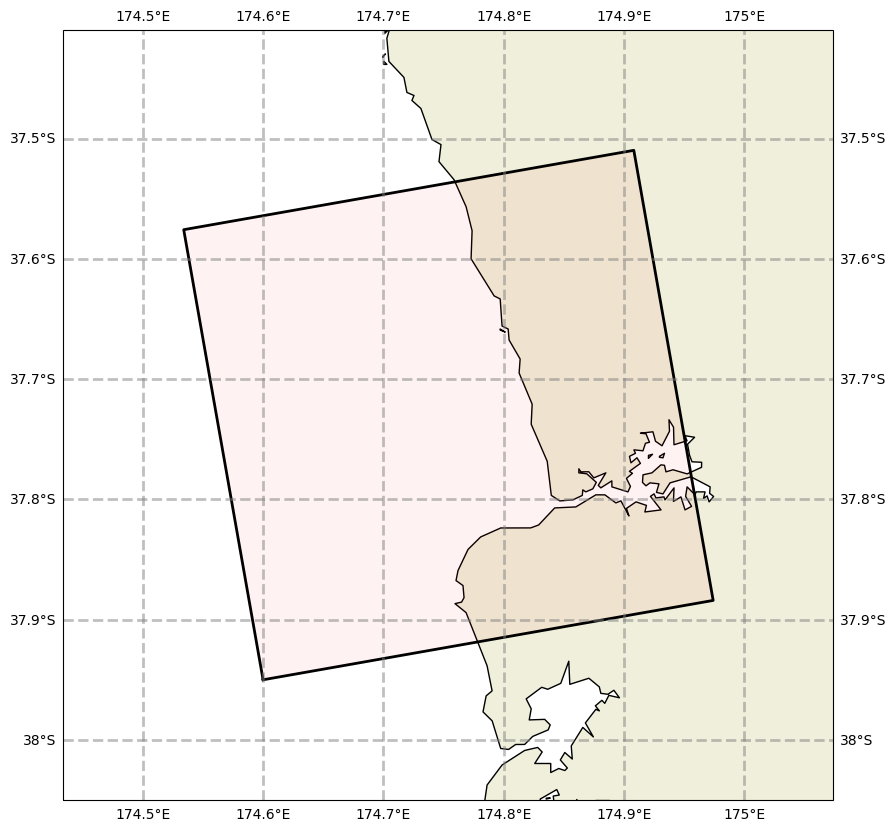

In [5]:
# Check the grid

run.config.grid.plot()

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'time = 2023-01-01'}, xlabel='longitude', ylabel='latitude'>)

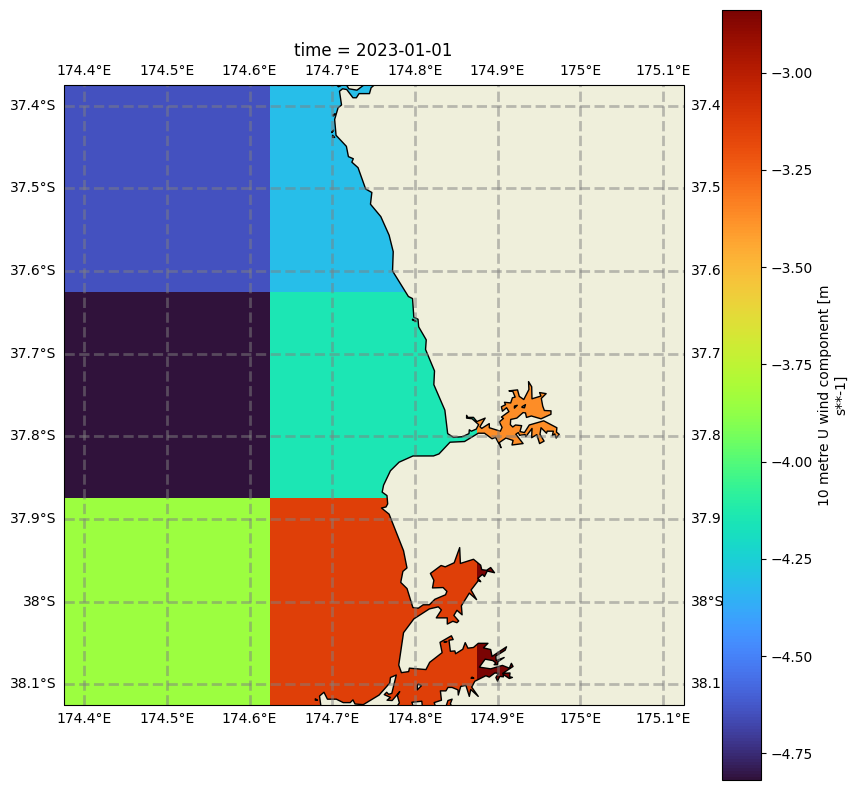

In [6]:
# Plot a single time step of the wind as a check
# (note that these next three lines are done internally within the wrapper, 
# we may want to write convenience mtethods for this)

run.config.forcing.wind._filter_grid(grid=run.config.grid)
run.config.forcing.wind._filter_time(time=run.period)
run.config.forcing.wind.plot(isel={'time': 0}, param='u10')

In [7]:
run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
period: 

	Start: 2023-01-01 00:00:00
	End: 2023-01-01 06:00:00
	Duration: 6:00:00
	Interval: 1:00:00
	Include End: True


output_dir: 
simulations

config: 
grid: 
	SwanGrid: REG, 20x20
spectral_resolution: 
	fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: 
	bottom: DatasetIntake(catalog_uri=../rompy/catalogs/oceanum.yaml, dataset_id=gebco_2022)
	wind: DatasetIntake(catalog_uri=../rompy/catalogs/oceanum.yaml, dataset_id=era5_wind10m)
	boundary: DatasetIntake(catalog_uri=../rompy/catalogs/oceanum.yaml, dataset_id=oceanum_wave_glob05_era5_v1_spec)

physics: 
	friction='MAD' friction_coeff=0.1
outputs: 
	Grid:
	variables: DEPTH UBOT HSIGN HSWELL DIR TPS TM01 WIND
	Spec
		locations:   -37.96 174.61
  -37.96 174.62
  -37.97 174.62


template: 
	/source/rompy/rompy/templates/swan

INFO:rompy.model:-----------------------------------------------------
I

'/source/rompy/notebooks/simulations/oceanum'

## Run SWAN

In [8]:
# Run the model

!docker run  -v ./simulations/oceanum:/home oceanum/swan:4141 swan.exe 


 SWAN is preparing computation

+SWAN is processing output request    1
+SWAN is processing output request    2
+time 20230101.001500   , step      1; iteration    1; sweep 1
+time 20230101.001500   , step      1; iteration    1; sweep 2
+time 20230101.001500   , step      1; iteration    1; sweep 3
+time 20230101.001500   , step      1; iteration    1; sweep 4
+time 20230101.001500   , step      1; iteration    2; sweep 1
+time 20230101.001500   , step      1; iteration    2; sweep 2
+time 20230101.001500   , step      1; iteration    2; sweep 3
+time 20230101.001500   , step      1; iteration    2; sweep 4
+time 20230101.001500   , step      1; iteration    3; sweep 1
+time 20230101.001500   , step      1; iteration    3; sweep 2
+time 20230101.001500   , step      1; iteration    3; sweep 3
+time 20230101.001500   , step      1; iteration    3; sweep 4
+time 20230101.001500   , step      1; iteration    4; sweep 1
+time 20230101.001500   , step      1; iteration    4; sweep 2
+time

## Plot outputs

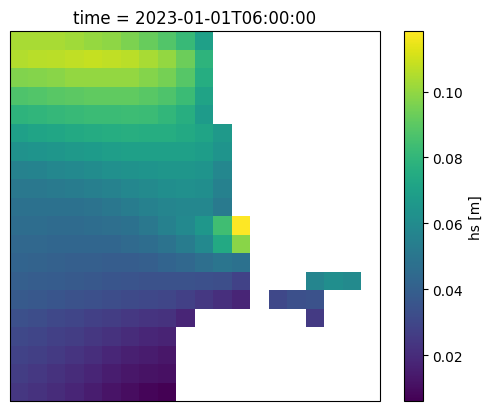

In [12]:
import xarray as xr
from cartopy import crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
output = xr.open_dataset('simulations/oceanum/outputs/swan_out.nc')
output.hs.isel(time=-1).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

In [8]:
# Zip the run 
# run.zip()

'simulations/oceanum/simulation.zip'